# IEEE Challenge 2021 Track1 Session-aware Recommendation with Transformer Session Prediction

We will implement a model to predict which session the user has purchased.

Input：
1. 9 products displayed to users (emb, discrete attributes, continuous attributes of products)
3. User's click history (emb, discrete attributes, continuous attributes of products)
3. User attributes (discrete attributes)

Output:
1. The user purchased in the session (purchased 0-3, 4-6, 7-9, three types of sessions)
2. Whether the user bought these 9 products (you can use the 4 types of product reweighting loss mentioned by Gaochen)

In [ ]:
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/train.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/item_info.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/track1_testset.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/track2_testset.parquet.snappy

train.parquet.snapp 100%[===================>]  65.26M   176MB/s    in 0.4s    
item_info.parquet.s 100%[===================>]  10.06K  --.-KB/s    in 0s      
track1_testset.parq 100%[===================>]  48.66M   165MB/s    in 0.3s    
track2_testset.parq 100%[===================>]  43.19M   143MB/s    in 0.3s    


In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.utils import shuffle

In [ ]:
import einops

## model

In [ ]:
class SessionPredictionModel(nn.Module):
    def __init__(self, 
                 num_items,
                 dim_item_emb=64,
                 dim_item_discrete_feature_emb=16,
                 dim_user_discrete_feature_emb=16,
                ):
        super().__init__()
        self.num_items = num_items
        self.NUM_ITEM_DISCRETE_FEATURE = 3+1 # item_vec3 + location1
        self.NUM_ITEM_CONT_FEATURE = 2+1 # item_vec2 + price1
        self.NUM_USER_DISCRETE_FEATURE = 10
        self.dim_item_emb = dim_item_emb
        self.dim_item_discrete_feature_emb = dim_item_discrete_feature_emb
        self.dim_user_discrete_feature_emb = dim_user_discrete_feature_emb

        # item emb
        self.item_emb = nn.Embedding(self.num_items + 1, self.dim_item_emb) # num_items + 1

        # item discrete feature
        self.item_discrete_feature_emb_list = nn.ModuleList()
        num_unique_value_list = [4, 10, 2, 3]
        for i in range(self.NUM_ITEM_DISCRETE_FEATURE):
            num_unique_value = num_unique_value_list[i]
            self.item_discrete_feature_emb_list.append(
                nn.Embedding(num_unique_value, self.dim_item_discrete_feature_emb)
            )
        
        # user discrete feature
        self.user_discrete_feature_emb_list = nn.ModuleList()
        num_unique_value_list = [3, 1430, 20, 10, 198, 52, 3, 13, 2, 2347]
        for i in range(self.NUM_USER_DISCRETE_FEATURE):
            num_unique_value = num_unique_value_list[i]
            self.user_discrete_feature_emb_list.append(
                nn.Embedding(num_unique_value, self.dim_user_discrete_feature_emb)
            )

        # backbone
        self.backbone = nn.Sequential(
            nn.Linear(
                # user_click_history
                self.dim_item_emb + self.NUM_ITEM_DISCRETE_FEATURE * self.dim_item_discrete_feature_emb + self.NUM_ITEM_CONT_FEATURE + 
                # nine items
                9 * (self.dim_item_emb + self.NUM_ITEM_DISCRETE_FEATURE * self.dim_item_discrete_feature_emb + self.NUM_ITEM_CONT_FEATURE) +
                # user
                self.NUM_USER_DISCRETE_FEATURE * self.dim_user_discrete_feature_emb
                , 400), 
            nn.PReLU(),
            nn.Linear(400, 200),
            nn.PReLU()
        )

        # session prediction head
        self.session_prediction_head = nn.Sequential(
            nn.Linear(200, 80),
            nn.PReLU(),
            nn.Linear(80, 20),
            nn.PReLU(),
            nn.Linear(20, 4)
        )

        # buy prediction head
        self.buy_prediction_head = nn.Sequential(
            nn.Linear(200, 80),
            nn.PReLU(),
            nn.Linear(80, 20),
            nn.PReLU(),
            nn.Linear(20, 9)
        )

    def get_item_emb_attr(self, 
                          item_id, 
                          item_cont_feature, 
                          item_discrete_feature):
        """
        param:
            item_id:                [N, 9]
            item_cont_feature:     [N, 9, NUM_ITEM_CONT_FEATURE]
            item_discrete_feature: [N, 9, NUM_USER_DISCRETE_FEATURE]
        
        return: 
            emb_attr:
                [N, 9, dim_item_emb
                       + NUM_ITEM_CONT_FEATURE
                       + NUM_USER_DISCRETE_FEATURE * dim_user_discrete_feature_emb
                ]

        note: 
            above, 9 can be an arbitrary number, e.g. 400
        """
        
        # item emb
        item_emb = self.item_emb(item_id) # [N, 9, dim_item_emb]
        
        # item discrete feature emb
        tmp = []
        for i in range(self.NUM_ITEM_DISCRETE_FEATURE):
            # print(i)
            # print(item_discrete_feature[:, i])
            tmp.append(
                self.item_discrete_feature_emb_list[i](item_discrete_feature[:, :, i]) # [N, 9, dim_user_discrete_feature_emb]
            )
        item_discrete_feature_emb = torch.cat(tmp, dim=-1)

        # concat [N, 9, D]
        emb_attr = torch.cat([
             item_emb, 
             item_discrete_feature_emb, 
             item_cont_feature
        ], dim=-1)

        return emb_attr

    def forward(self,
                user_click_history, user_click_history_discrete_feature, user_click_history_cont_feature, num_user_click_history,
                item_id, item_discrete_feature, item_cont_feature,
                user_discrete_feature,
                ):
        """
            user_click_history: [N, 400]
            user_click_history_discrete_feature: [N, 400, 3+1]
            user_click_history_cont_feature: [N, 400, 2+1]
            num_user_click_history: [N, 1]

            item_id: [N, 9]
            item_discrete_feature: [N, 9, 3+1] item_vec3 + location1
            item_cont_feature: [N, 9, 2+1] item_vec2 + price1

            user_discrete_feature: [N, 10]
        """

        batch_size = user_click_history.size()[0]
        
        tmp = self.get_item_emb_attr(user_click_history, 
                                     user_click_history_cont_feature, 
                                     user_click_history_discrete_feature) # [N, 400, D]
        user_click_history_emb = torch.zeros( # [N, D]
            (batch_size, self.dim_item_emb
                         + self.NUM_ITEM_CONT_FEATURE
                         + self.NUM_ITEM_DISCRETE_FEATURE * self.dim_item_discrete_feature_emb)
        )
        for i in range(batch_size):
            aa = tmp[i, :num_user_click_history[i], :] # [N, 400, D] -> [400-, D]
            a = torch.mean(aa, dim=0) # [400-, D] -> [D]
            user_click_history_emb[i] = a

        nine_item_emb = self.get_item_emb_attr(item_id, 
                                               item_cont_feature, 
                                               item_discrete_feature) # [N, 9, D]
        nine_item_emb = einops.rearrange(nine_item_emb, 'N B D -> N (B D)') # [N, 9D]

        tmp = []
        for i in range(self.NUM_USER_DISCRETE_FEATURE):
            tmp.append(
                self.user_discrete_feature_emb_list[i](user_discrete_feature[:, i]) # [N, dim_user_discrete_feature_emb]
            )
        user_discrete_feature_emb = torch.cat(tmp, dim=1)

        all_emb = torch.cat([user_click_history_emb, 
                             nine_item_emb,
                             user_discrete_feature_emb,
                            ], dim=1) # [N, D]
        
        feat = self.backbone(all_emb) # [N, 1]
        session_pred = self.session_prediction_head(feat)
        buy_pred = self.buy_prediction_head(feat)
        return session_pred, buy_pred # [N, 4], [N, 9]

In [ ]:
m = SessionPredictionModel(num_items=381,
                           dim_item_emb=64,
                           dim_item_discrete_feature_emb=16,
                           dim_user_discrete_feature_emb=16
                           )

B = 7
m(
    user_click_history=torch.ones([B, 400], dtype=torch.int32),
    user_click_history_discrete_feature=torch.ones([B, 400, 4], dtype=torch.int32),
    user_click_history_cont_feature=torch.randn([B, 400, 3]),
    num_user_click_history=torch.ones([B, 1], dtype=torch.int32) * 10,
    user_discrete_feature=torch.ones([B, 10], dtype=torch.int32),
    item_id=torch.ones([B, 9], dtype=torch.int32),
    item_discrete_feature=torch.ones([B, 9, 4], dtype=torch.int32),
    item_cont_feature=torch.randn([B, 9, 3]),
)

(tensor([[ 0.0775,  0.1296, -0.0822,  0.1355],
         [ 0.0767,  0.1306, -0.0808,  0.1321],
         [ 0.0758,  0.1314, -0.0804,  0.1332],
         [ 0.0798,  0.1342, -0.0775,  0.1337],
         [ 0.0778,  0.1322, -0.0775,  0.1320],
         [ 0.0765,  0.1345, -0.0756,  0.1293],
         [ 0.0715,  0.1263, -0.0839,  0.1334]], grad_fn=<AddmmBackward>),
 tensor([[ 0.0648, -0.1751,  0.1935,  0.1635,  0.0325, -0.1246, -0.0648,  0.0386,
           0.1493],
         [ 0.0718, -0.1808,  0.1902,  0.1653,  0.0309, -0.1241, -0.0585,  0.0373,
           0.1511],
         [ 0.0656, -0.1761,  0.1942,  0.1630,  0.0353, -0.1242, -0.0632,  0.0388,
           0.1508],
         [ 0.0570, -0.1684,  0.1963,  0.1594,  0.0412, -0.1287, -0.0629,  0.0395,
           0.1486],
         [ 0.0695, -0.1782,  0.1937,  0.1638,  0.0346, -0.1236, -0.0612,  0.0381,
           0.1489],
         [ 0.0713, -0.1777,  0.1892,  0.1659,  0.0320, -0.1250, -0.0610,  0.0403,
           0.1522],
         [ 0.0629, -0.1805,  0.1

## data

In [ ]:
## user portrait
data_path='/content'
# portraitidx_to_idx_dict_list: list of 10 dict, int:int

portraitidx_to_idx_dict_list = []
for i in range(10):
    portraitidx_to_idx_dict_list.append(dict())
acculumated_idx = [0] * 10


df_train = pd.read_parquet(f'{data_path}/trainset.parquet.snappy')
for i in tqdm(range(df_train.shape[0])):
    user_portrait = [int(s) for s in df_train.at[i, 'user_protrait'].split(',')]
    for idx, u in enumerate(user_portrait):
        if portraitidx_to_idx_dict_list[idx].get(u, -1) == -1:
            portraitidx_to_idx_dict_list[idx][u] = acculumated_idx[idx]
            acculumated_idx[idx] += 1

df_test1 = pd.read_parquet(f'{data_path}/track1_testset.parquet.snappy')
for i in tqdm(range(df_test1.shape[0])):
    user_portrait = [int(s) for s in df_test1.at[i, 'user_protrait'].split(',')]
    for idx, u in enumerate(user_portrait):
        if portraitidx_to_idx_dict_list[idx].get(u, -1) == -1:
            portraitidx_to_idx_dict_list[idx][u] = acculumated_idx[idx]
            acculumated_idx[idx] += 1

df_test2 = pd.read_parquet(f'{data_path}/track2_testset.parquet.snappy')
for i in tqdm(range(df_test2.shape[0])):
    user_portrait = [int(s) for s in df_test2.at[i, 'user_protrait'].split(',')]
    for idx, u in enumerate(user_portrait):
        if portraitidx_to_idx_dict_list[idx].get(u, -1) == -1:
            portraitidx_to_idx_dict_list[idx][u] = acculumated_idx[idx]
            acculumated_idx[idx] += 1

acculumated_idx

100%|██████████| 206096/206096 [00:01<00:00, 104513.47it/s]


[3, 1430, 20, 10, 198, 52, 3, 13, 2, 2347]

In [ ]:
def load_item_info(data_path='/content'):
    # item info
    df_item_info = pd.read_parquet(f'{data_path}/item_info.parquet.snappy')
    item_info_dict = {}
    for i in tqdm(range(df_item_info.shape[0])):
        item_id = df_item_info.at[i, 'item_id'] 

        item_discrete = df_item_info.at[i, 'item_vec'].split(',')[:3]
        item_cont = df_item_info.at[i, 'item_vec'].split(',')[-2:]
        price = df_item_info.at[i, 'price'] / 3000
        loc = df_item_info.at[i, 'location'] - 1 # 0~2

        item_cont.append(price) # 2 + 1
        item_discrete.append(loc) # 3 + 1

        item_cont = [float(it) for it in item_cont]
        item_discrete = [int(it) for it in item_discrete]
        item_discrete[0] = item_discrete[0] - 1 # 1~4 -> 0~3
        item_discrete[2] = item_discrete[2] - 1 # 1~2 -> 0~1

        item_info_dict[int(item_id)] = {
            'cont': np.array(item_cont, dtype=np.float64),
            'discrete': np.array(item_discrete, dtype=np.int64),
        }
    return item_info_dict

In [ ]:
item_info_dict = load_item_info(data_path='/content')

100%|██████████| 381/381 [00:00<00:00, 30668.83it/s]


In [ ]:
def load_train_data(data_path='/content'):
    # trainset
    train_samples = []
    val_samples = []
    df_train = pd.read_parquet(f'{data_path}/trainset.parquet.snappy')

    # shuffle
    df_train = shuffle(df_train, random_state=2333).reset_index()
    total_num = int(df_train.shape[0])
    num_train = int(total_num * 0.95)
    num_val = total_num - num_train # 5% validation data

    for i in tqdm(range(total_num)):
        if df_train.at[i, 'user_click_history'] == '0:0':
            user_click_list = [0]
        else:
            user_click_list = df_train.at[i, 'user_click_history'].split(',')
            user_click_list = [int(sample.split(':')[0]) for sample in user_click_list]
        num_user_click_history = len(user_click_list)
        tmp = np.zeros(400, dtype=np.int64)
        tmp[:len(user_click_list)] = user_click_list
        user_click_list = tmp
        
        exposed_items = [int(s) for s in df_train.at[i, 'exposed_items'].split(',')]
        labels = [int(s) for s in df_train.at[i, 'labels'].split(',')]

        user_portrait = [int(s) for s in df_train.at[i, 'user_protrait'].split(',')]
        # portraitidx_to_idx_dict_list: list of 10 dict, int:int
        for j in range(10):
            user_portrait[j] = portraitidx_to_idx_dict_list[j][user_portrait[j]]
        one_sample = {
            'user_click_list': user_click_list,
            'num_user_click_history': num_user_click_history,
            'user_portrait': np.array(user_portrait, dtype=np.int64),
            'item_id': np.array(exposed_items, dtype=np.int64),
            'label': np.array(labels, dtype=np.int64)
        }
        if i < num_train:
            train_samples.append(one_sample)
        else:
            val_samples.append(one_sample)
    return train_samples, val_samples

In [ ]:
train_samples, val_samples = load_train_data(data_path='/content')

100%|██████████| 260087/260087 [00:16<00:00, 15343.40it/s]


In [ ]:
class BigDataCupDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 item_info_dict,
                 database
                ):
        super().__init__()
        self.item_info_dict = item_info_dict
        self.database = database

    def __len__(self, ):
        return len(self.database)

    def __getitem__(self, idx):
        one_sample = self.database[idx]
        user_click_history = one_sample['user_click_list']
        num_user_click_history = one_sample['num_user_click_history']
        user_discrete_feature = one_sample['user_portrait']
        item_id = one_sample['item_id']
        label = one_sample['label']

        user_click_history_discrete_feature = np.zeros((400, 3+1)).astype(np.int64)
        user_click_history_cont_feature = np.zeros((400, 2+1)).astype(np.float64)
        for i in range(num_user_click_history):
            if user_click_history[i] == 0:
                continue
            else:
                user_click_history_discrete_feature[i] = self.item_info_dict[user_click_history[i]]['discrete']
                user_click_history_cont_feature[i] = self.item_info_dict[user_click_history[i]]['cont']

        item_discrete_feature = np.zeros((9, 3+1)).astype(np.int64)
        item_cont_feature = np.zeros((9, 2+1)).astype(np.float64)
        for i in range(9):
            item_discrete_feature[i] = self.item_info_dict[item_id[i]]['discrete']
            item_cont_feature[i] = self.item_info_dict[item_id[i]]['cont']

        session_label = 0 # 0,1,2,3
        for i in range(9):
            if label[i]:
                session_label = 1
            if i >= 3 and label[i]:
                session_label = 2
            if i >= 6 and label[i]:
                session_label = 3

        user_click_history = torch.IntTensor(user_click_history)
        user_click_history_discrete_feature = torch.IntTensor(user_click_history_discrete_feature)
        user_click_history_cont_feature = torch.FloatTensor(user_click_history_cont_feature)
        num_user_click_history = torch.IntTensor([num_user_click_history])
        user_discrete_feature = torch.IntTensor(user_discrete_feature)
        item_id = torch.IntTensor(item_id)
        item_discrete_feature = torch.IntTensor(item_discrete_feature)
        item_cont_feature = torch.FloatTensor(item_cont_feature)
        label = torch.IntTensor(label)
        session_label = session_label
        
        return user_click_history, \
            user_click_history_discrete_feature, user_click_history_cont_feature, \
            num_user_click_history, \
            item_id, item_discrete_feature, item_cont_feature, \
            user_discrete_feature, label, session_label

In [ ]:
ds = BigDataCupDataset(item_info_dict, train_samples)

In [ ]:
train_samples, val_samples = load_train_data()

train_ds = BigDataCupDataset(item_info_dict, train_samples)
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=32, shuffle=True)

val_ds = BigDataCupDataset(item_info_dict, val_samples)
val_dl = torch.utils.data.DataLoader(dataset=val_ds, batch_size=32, shuffle=False)

100%|██████████| 260087/260087 [00:16<00:00, 15312.28it/s]


## train

In [ ]:
def binary_acc(sess_pred, y_pred, y_test):
    # print(sess_pred)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred_tag_intact = y_pred_tag.clone()


    ##################################
    ## vanilla
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc1 = correct_results_sum / y_test.shape[0] / 9

    real_acc1 = 0.0
    for i in range(y_test.shape[0]):
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        one_acc = correct_results_sum / 9
        if one_acc == 1:
            real_acc1 += 1
    real_acc1 = real_acc1 / y_test.shape[0]
    # print(y_pred_tag)

    ####################################
    ## use sess to refine y_pred_tag
    for i in range(y_test.shape[0]):
        if sess_pred[i] == 0:
            y_pred_tag[i][:] = 0
        elif sess_pred[i] == 1:
            y_pred_tag[i][3:] = 0
        elif sess_pred[i] == 2:
            y_pred_tag[i][:3] = 1
            y_pred_tag[i][6:] = 0
        elif sess_pred[i] == 3:
            y_pred_tag[i][:6] = 1

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc2 = correct_results_sum / y_test.shape[0] / 9

    real_acc2 = 0.0
    for i in range(y_test.shape[0]):
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        one_acc = correct_results_sum / 9
        if one_acc == 1:
            real_acc2 += 1
    real_acc2 = real_acc2 / y_test.shape[0]
    # print(y_pred_tag)

    #######################################
    ## rule 2
    y_pred_tag = y_pred_tag_intact
    acc_rule2 = 0.0
    real_acc_rule2 = 0.0
    for i in range(y_test.shape[0]):
        for j in range(9):
            k = 8 - j
            if k >= 6 and y_pred_tag[i][k] == 1:
                y_pred_tag[i][:6] = 1
            if k >= 3 and y_pred_tag[i][k] == 1:
                y_pred_tag[i][:3] = 1
        
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        a = correct_results_sum / 9
        acc_rule2 += a
        if a == 1:
            real_acc_rule2 += 1
    acc_rule2 = acc_rule2 / y_test.shape[0]
    real_acc_rule2 = real_acc_rule2 / y_test.shape[0]
    # print(y_pred_tag)


    return acc1, acc2, acc_rule2, real_acc1, real_acc2, real_acc_rule2

In [ ]:
model = SessionPredictionModel(num_items=381,
    dim_item_emb=32,
    dim_item_discrete_feature_emb=8,
    dim_user_discrete_feature_emb=8
)

In [ ]:
model

SessionPredictionModel(
  (item_emb): Embedding(382, 32)
  (item_discrete_feature_emb_list): ModuleList(
    (0): Embedding(4, 8)
    (1): Embedding(10, 8)
    (2): Embedding(2, 8)
    (3): Embedding(3, 8)
  )
  (user_discrete_feature_emb_list): ModuleList(
    (0): Embedding(3, 8)
    (1): Embedding(1430, 8)
    (2): Embedding(20, 8)
    (3): Embedding(10, 8)
    (4): Embedding(198, 8)
    (5): Embedding(52, 8)
    (6): Embedding(3, 8)
    (7): Embedding(13, 8)
    (8): Embedding(2, 8)
    (9): Embedding(2347, 8)
  )
  (backbone): Sequential(
    (0): Linear(in_features=750, out_features=400, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): PReLU(num_parameters=1)
  )
  (session_prediction_head): Sequential(
    (0): Linear(in_features=200, out_features=80, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=80, out_features=20, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=

In [ ]:
sess_criterion = nn.CrossEntropyLoss()
buy_criterion = nn.BCEWithLogitsLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

NUM_EPOCH = 2
for epoch_idx in range(NUM_EPOCH):  # loop over the dataset multiple times

    running_sess_loss = 0.0
    running_buy_loss = 0.0
    train_cnt = 0
    train_sess_acc_sum = 0
    train_buy_acc1_sum = 0
    train_buy_real_acc1_sum = 0
    train_buy_acc2_sum = 0
    train_buy_real_acc2_sum = 0
    train_buy_acc_rule2_sum = 0
    train_buy_real_acc_rule2_sum = 0
    train_cnt_session_0 = train_cnt_session_1 = train_cnt_session_2 = train_cnt_session_3 = 0
    
    for i, data in enumerate(train_dl, 0):
        model.train()

        # get the inputs; data is a list of [inputs, labels]
        user_click_history, \
            user_click_history_discrete_feature, user_click_history_cont_feature, \
            num_user_click_history, \
            item_id, item_discrete_feature, item_cont_feature, \
            user_discrete_feature, label, session_label = data

        train_batch_size = user_click_history.shape[0]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        sess_outputs, buy_outputs = model(
            user_click_history,
            user_click_history_discrete_feature,
            user_click_history_cont_feature,
            num_user_click_history,
            item_id,
            item_discrete_feature,
            item_cont_feature,
            user_discrete_feature
        )

        sess_loss = sess_criterion(sess_outputs, session_label)
        buy_loss = buy_criterion(buy_outputs, label.float())
        loss = sess_loss + buy_loss

        loss.backward()
        optimizer.step()

        # print statistics
        running_sess_loss += sess_loss.item()
        running_buy_loss += buy_loss.item()

        _, sess_predicted = torch.max(sess_outputs.data, 1)
        sess_acc = (sess_predicted == session_label).sum().item() / train_batch_size
        # buy_acc1, buy_acc2, buy_real_acc1, buy_real_acc2 = binary_acc(sess_predicted, buy_outputs, label)
        buy_acc1, buy_acc2, buy_acc_rule2, buy_real_acc1, buy_real_acc2, buy_real_acc_rule2 = binary_acc(sess_predicted, buy_outputs, label)

        train_sess_acc_sum += sess_acc
        train_buy_acc1_sum += buy_acc1
        train_buy_real_acc1_sum += buy_real_acc1
        train_buy_acc2_sum += buy_acc2
        train_buy_real_acc2_sum += buy_real_acc2
        train_buy_acc_rule2_sum += buy_acc_rule2
        train_buy_real_acc_rule2_sum += buy_real_acc_rule2
        train_cnt += 1

        train_cnt_session_0 += torch.sum(session_label == 0)
        train_cnt_session_1 += torch.sum(session_label == 1)
        train_cnt_session_2 += torch.sum(session_label == 2)
        train_cnt_session_3 += torch.sum(session_label == 3)

        if i % 50 == 1:
            print(i, )

        if i % 500 == 1:    # print every 2000 mini-batches
            print('----- TRAIN -----')
            print('[%d, %5d] sess loss: %.3f' % (epoch_idx + 1, i + 1, running_sess_loss / train_cnt))
            print('[%d, %5d] buy loss: %.3f'  % (epoch_idx + 1, i + 1, running_buy_loss / train_cnt))
            print('- sess acc:', train_sess_acc_sum / train_cnt, flush=True)
            print('- buy acc1:', train_buy_acc1_sum / train_cnt, flush=True)
            print('- buy real acc1:', train_buy_real_acc1_sum / train_cnt, flush=True)
            print('- buy acc2:', train_buy_acc2_sum / train_cnt, flush=True)
            print('- buy real acc2:', train_buy_real_acc2_sum / train_cnt, flush=True)
            print('- buy acc rule2:', train_buy_acc_rule2_sum / train_cnt, flush=True)
            print('- buy real acc rule2:', train_buy_real_acc_rule2_sum / train_cnt, flush=True)
            print('- train sess cnt:', train_cnt_session_0, train_cnt_session_1, train_cnt_session_2, train_cnt_session_3)

            running_sess_loss = 0.0
            running_buy_loss = 0.0
            train_cnt = 0
            train_sess_acc_sum = 0
            train_buy_acc1_sum = 0
            train_buy_real_acc1_sum = 0
            train_buy_acc2_sum = 0
            train_buy_real_acc2_sum = 0
            train_buy_acc_rule2_sum = 0
            train_buy_real_acc_rule2_sum = 0
            train_cnt_session_0 = train_cnt_session_1 = train_cnt_session_2 = train_cnt_session_3 = 0


            ## val
            model.eval()
            valid_cnt = 0
            valid_sess_acc_sum = 0
            valid_buy_acc1_sum = 0
            valid_buy_real_acc1_sum = 0
            valid_buy_acc2_sum = 0
            valid_buy_real_acc2_sum = 0
            valid_buy_acc_rule2_sum = 0
            valid_buy_real_acc_rule2_sum = 0
            
            valid_cnt_session_0 = valid_cnt_session_1 = valid_cnt_session_2 = valid_cnt_session_3 = 0

            for _, val_data in tqdm(enumerate(val_dl, 0)):
                user_click_history, \
                    user_click_history_discrete_feature, user_click_history_cont_feature, \
                    num_user_click_history, \
                    item_id, item_discrete_feature, item_cont_feature, \
                    user_discrete_feature, label, session_label = val_data
                sess_outputs, buy_outputs = model(
                    user_click_history,
                    user_click_history_discrete_feature,
                    user_click_history_cont_feature,
                    num_user_click_history,
                    item_id,
                    item_discrete_feature,
                    item_cont_feature,
                    user_discrete_feature
                )

                valid_batch_size = user_click_history.shape[0]

                _, sess_predicted = torch.max(sess_outputs.data, 1)
                sess_acc = (sess_predicted == session_label).sum().item() / valid_batch_size
                buy_acc1, buy_acc2, buy_acc_rule2, buy_real_acc1, buy_real_acc2, buy_real_acc_rule2 = binary_acc(sess_predicted, buy_outputs, label)

                valid_sess_acc_sum += sess_acc
                valid_buy_acc1_sum += buy_acc1
                valid_buy_real_acc1_sum += buy_real_acc1
                valid_buy_acc2_sum += buy_acc2
                valid_buy_real_acc2_sum += buy_real_acc2
                valid_buy_acc_rule2_sum += buy_acc_rule2
                valid_buy_real_acc_rule2_sum += buy_real_acc_rule2
                valid_cnt += 1

                valid_cnt_session_0 += torch.sum(session_label == 0)
                valid_cnt_session_1 += torch.sum(session_label == 1)
                valid_cnt_session_2 += torch.sum(session_label == 2)
                valid_cnt_session_3 += torch.sum(session_label == 3)

            print('----- VAL -----')
            print('- sess acc:', valid_sess_acc_sum / valid_cnt)
            print('- buy acc1:', valid_buy_acc1_sum / valid_cnt)
            print('- buy real acc1:', valid_buy_real_acc1_sum / valid_cnt)
            print('- buy acc2:', valid_buy_acc2_sum / valid_cnt)
            print('- buy real acc2:', valid_buy_real_acc2_sum / valid_cnt)
            print('- buy acc rule2:', valid_buy_acc_rule2_sum / valid_cnt)
            print('- buy real acc rule2:', valid_buy_real_acc_rule2_sum / valid_cnt)
            print('valid sess cnt:', valid_cnt_session_0, valid_cnt_session_1, valid_cnt_session_2, valid_cnt_session_3)

print('Finished Training')

1
----- TRAIN -----
[1,     2] sess loss: 1.130
[1,     2] buy loss: 0.462
- sess acc: 0.5625
- buy acc1: tensor(0.7951)
- buy real acc1: 0.34375
- buy acc2: tensor(0.7778)
- buy real acc2: 0.3125
- buy acc rule2: tensor(0.7951)
- buy real acc rule2: 0.34375
- train sess cnt: tensor(13) tensor(13) tensor(15) tensor(23)


407it [00:07, 57.00it/s]


----- VAL -----
- sess acc: 0.6497353997353997
- buy acc1: tensor(0.8032)
- buy real acc1: 0.32239297864297867
- buy acc2: tensor(0.8004)
- buy real acc2: 0.32408216783216787
- buy acc rule2: tensor(0.8032)
- buy real acc rule2: 0.3225465412965413
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
51
101
151
201
251
301
351
401
451
501
----- TRAIN -----
[1,   502] sess loss: 0.837
[1,   502] buy loss: 0.403
- sess acc: 0.6630625
- buy acc1: tensor(0.8125)
- buy real acc1: 0.328
- buy acc2: tensor(0.8105)
- buy real acc2: 0.330625
- buy acc rule2: tensor(0.8125)
- buy real acc rule2: 0.3284375
- train sess cnt: tensor(1866) tensor(3123) tensor(2347) tensor(8664)


407it [00:06, 58.47it/s]


----- VAL -----
- sess acc: 0.652995652995653
- buy acc1: tensor(0.8049)
- buy real acc1: 0.3154826592326593
- buy acc2: tensor(0.8027)
- buy real acc2: 0.3182054432054432
- buy acc rule2: tensor(0.8050)
- buy real acc rule2: 0.31578978453978457
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
551
601
651
701
751
801
851
901
951
1001
----- TRAIN -----
[1,  1002] sess loss: 0.828
[1,  1002] buy loss: 0.401
- sess acc: 0.67025
- buy acc1: tensor(0.8147)
- buy real acc1: 0.334375
- buy acc2: tensor(0.8131)
- buy real acc2: 0.3365625
- buy acc rule2: tensor(0.8148)
- buy real acc rule2: 0.3349375
- train sess cnt: tensor(1877) tensor(3131) tensor(2284) tensor(8708)


407it [00:07, 58.01it/s]


----- VAL -----
- sess acc: 0.6551455301455301
- buy acc1: tensor(0.8058)
- buy real acc1: 0.3219736344736345
- buy acc2: tensor(0.8038)
- buy real acc2: 0.3232375732375733
- buy acc rule2: tensor(0.8060)
- buy real acc rule2: 0.3224343224343224
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
1051
1101
1151
1201
1251
1301
1351
1401
1451
1501
----- TRAIN -----
[1,  1502] sess loss: 0.821
[1,  1502] buy loss: 0.397
- sess acc: 0.6763125
- buy acc1: tensor(0.8164)
- buy real acc1: 0.3365625
- buy acc2: tensor(0.8150)
- buy real acc2: 0.33975
- buy acc rule2: tensor(0.8164)
- buy real acc rule2: 0.337125
- train sess cnt: tensor(1916) tensor(3041) tensor(2322) tensor(8721)


407it [00:06, 58.22it/s]


----- VAL -----
- sess acc: 0.6561436873936874
- buy acc1: tensor(0.8055)
- buy real acc1: 0.32450741825741825
- buy acc2: tensor(0.8032)
- buy real acc2: 0.326692732942733
- buy acc rule2: tensor(0.8056)
- buy real acc rule2: 0.3251216688716689
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
1551
1601
1651
1701
1751
1801
1851
1901
1951
2001
----- TRAIN -----
[1,  2002] sess loss: 0.834
[1,  2002] buy loss: 0.400
- sess acc: 0.6671875
- buy acc1: tensor(0.8136)
- buy real acc1: 0.3260625
- buy acc2: tensor(0.8123)
- buy real acc2: 0.328
- buy acc rule2: tensor(0.8136)
- buy real acc rule2: 0.3263125
- train sess cnt: tensor(1934) tensor(3205) tensor(2306) tensor(8555)


407it [00:07, 57.89it/s]


----- VAL -----
- sess acc: 0.6559133434133434
- buy acc1: tensor(0.8062)
- buy real acc1: 0.32281822906822905
- buy acc2: tensor(0.8039)
- buy real acc2: 0.3254642317142317
- buy acc rule2: tensor(0.8063)
- buy real acc rule2: 0.3235860423360423
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
2051
2101
2151
2201
2251
2301
2351
2401
2451
2501
----- TRAIN -----
[1,  2502] sess loss: 0.822
[1,  2502] buy loss: 0.396
- sess acc: 0.6668125
- buy acc1: tensor(0.8158)
- buy real acc1: 0.33025
- buy acc2: tensor(0.8145)
- buy real acc2: 0.3329375
- buy acc rule2: tensor(0.8158)
- buy real acc rule2: 0.331
- train sess cnt: tensor(1897) tensor(3159) tensor(2255) tensor(8689)


407it [00:07, 57.00it/s]


----- VAL -----
- sess acc: 0.6561436873936874
- buy acc1: tensor(0.8066)
- buy real acc1: 0.32888395388395386
- buy acc2: tensor(0.8043)
- buy real acc2: 0.33007111132111133
- buy acc rule2: tensor(0.8066)
- buy real acc rule2: 0.32934464184464185
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
2551
2601
2651
2701
2751
2801
2851
2901
2951
3001
----- TRAIN -----
[1,  3002] sess loss: 0.840
[1,  3002] buy loss: 0.404
- sess acc: 0.66375
- buy acc1: tensor(0.8130)
- buy real acc1: 0.331125
- buy acc2: tensor(0.8123)
- buy real acc2: 0.3326875
- buy acc rule2: tensor(0.8130)
- buy real acc rule2: 0.3314375
- train sess cnt: tensor(1901) tensor(3107) tensor(2446) tensor(8546)


407it [00:07, 57.26it/s]


----- VAL -----
- sess acc: 0.6563740313740314
- buy acc1: tensor(0.8066)
- buy real acc1: 0.3238163863163863
- buy acc2: tensor(0.8043)
- buy real acc2: 0.3254642317142317
- buy acc rule2: tensor(0.8067)
- buy real acc rule2: 0.32450741825741825
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
3051
3101
3151
3201
3251
3301
3351
3401
3451
3501
----- TRAIN -----
[1,  3502] sess loss: 0.826
[1,  3502] buy loss: 0.399
- sess acc: 0.6735
- buy acc1: tensor(0.8139)
- buy real acc1: 0.335625
- buy acc2: tensor(0.8124)
- buy real acc2: 0.337125
- buy acc rule2: tensor(0.8138)
- buy real acc rule2: 0.3364375
- train sess cnt: tensor(1920) tensor(3132) tensor(2293) tensor(8655)


407it [00:07, 56.31it/s]


----- VAL -----
- sess acc: 0.6575257512757513
- buy acc1: tensor(0.8071)
- buy real acc1: 0.32373960498960497
- buy acc2: tensor(0.8052)
- buy real acc2: 0.3261552636552637
- buy acc rule2: tensor(0.8071)
- buy real acc rule2: 0.3241235116235116
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
3551
3601
3651
3701
3751
3801
3851
3901
3951
4001
----- TRAIN -----
[1,  4002] sess loss: 0.822
[1,  4002] buy loss: 0.399
- sess acc: 0.6701875
- buy acc1: tensor(0.8134)
- buy real acc1: 0.3325625
- buy acc2: tensor(0.8115)
- buy real acc2: 0.333875
- buy acc rule2: tensor(0.8133)
- buy real acc rule2: 0.33325
- train sess cnt: tensor(1837) tensor(3085) tensor(2359) tensor(8719)


407it [00:07, 57.47it/s]


----- VAL -----
- sess acc: 0.6566043753543753
- buy acc1: tensor(0.8074)
- buy real acc1: 0.32719476469476466
- buy acc2: tensor(0.8053)
- buy real acc2: 0.32853548478548483
- buy acc rule2: tensor(0.8074)
- buy real acc rule2: 0.32765545265545265
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
4051
4101
4151
4201
4251
4301
4351
4401
4451
4501
----- TRAIN -----
[1,  4502] sess loss: 0.815
[1,  4502] buy loss: 0.395
- sess acc: 0.671125
- buy acc1: tensor(0.8159)
- buy real acc1: 0.3405
- buy acc2: tensor(0.8144)
- buy real acc2: 0.341125
- buy acc rule2: tensor(0.8160)
- buy real acc rule2: 0.3411875
- train sess cnt: tensor(1863) tensor(3028) tensor(2374) tensor(8735)


407it [00:07, 57.28it/s]


----- VAL -----
- sess acc: 0.6575257512757513
- buy acc1: tensor(0.8070)
- buy real acc1: 0.3290375165375165
- buy acc2: tensor(0.8051)
- buy real acc2: 0.3305317992817993
- buy acc rule2: tensor(0.8071)
- buy real acc rule2: 0.3295749858249858
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
4551
4601
4651
4701
4751
4801
4851
4901
4951
5001
----- TRAIN -----
[1,  5002] sess loss: 0.822
[1,  5002] buy loss: 0.395
- sess acc: 0.667625
- buy acc1: tensor(0.8162)
- buy real acc1: 0.3355625
- buy acc2: tensor(0.8150)
- buy real acc2: 0.33925
- buy acc rule2: tensor(0.8160)
- buy real acc rule2: 0.336125
- train sess cnt: tensor(1935) tensor(3093) tensor(2345) tensor(8627)


407it [00:07, 58.03it/s]


----- VAL -----
- sess acc: 0.6572954072954073
- buy acc1: tensor(0.8071)
- buy real acc1: 0.32619660744660745
- buy acc2: tensor(0.8048)
- buy real acc2: 0.3281515781515782
- buy acc rule2: tensor(0.8071)
- buy real acc rule2: 0.32673407673407673
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
5051
5101
5151
5201
5251
5301
5351
5401
5451
5501
----- TRAIN -----
[1,  5502] sess loss: 0.832
[1,  5502] buy loss: 0.402
- sess acc: 0.6665
- buy acc1: tensor(0.8118)
- buy real acc1: 0.328375
- buy acc2: tensor(0.8098)
- buy real acc2: 0.330125
- buy acc rule2: tensor(0.8120)
- buy real acc rule2: 0.328875
- train sess cnt: tensor(1923) tensor(3089) tensor(2362) tensor(8626)


407it [00:06, 58.18it/s]


----- VAL -----
- sess acc: 0.6563740313740314
- buy acc1: tensor(0.8077)
- buy real acc1: 0.3295749858249858
- buy acc2: tensor(0.8048)
- buy real acc2: 0.3313763938763939
- buy acc rule2: tensor(0.8077)
- buy real acc rule2: 0.3300356737856738
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
5551
5601
5651
5701
5751
5801
5851
5901
5951
6001
----- TRAIN -----
[1,  6002] sess loss: 0.822
[1,  6002] buy loss: 0.394
- sess acc: 0.671
- buy acc1: tensor(0.8169)
- buy real acc1: 0.33725
- buy acc2: tensor(0.8157)
- buy real acc2: 0.3385625
- buy acc rule2: tensor(0.8170)
- buy real acc rule2: 0.338
- train sess cnt: tensor(1911) tensor(3062) tensor(2352) tensor(8675)


407it [00:06, 58.36it/s]


----- VAL -----
- sess acc: 0.6576025326025327
- buy acc1: tensor(0.8080)
- buy real acc1: 0.32888395388395386
- buy acc2: tensor(0.8055)
- buy real acc2: 0.3312996125496126
- buy acc rule2: tensor(0.8081)
- buy real acc rule2: 0.3298053298053298
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
6051
6101
6151
6201
6251
6301
6351
6401
6451
6501
----- TRAIN -----
[1,  6502] sess loss: 0.824
[1,  6502] buy loss: 0.398
- sess acc: 0.6705625
- buy acc1: tensor(0.8166)
- buy real acc1: 0.3371875
- buy acc2: tensor(0.8148)
- buy real acc2: 0.338875
- buy acc rule2: tensor(0.8167)
- buy real acc rule2: 0.338
- train sess cnt: tensor(1874) tensor(3072) tensor(2367) tensor(8687)


407it [00:06, 58.19it/s]


----- VAL -----
- sess acc: 0.6580632205632205
- buy acc1: tensor(0.8080)
- buy real acc1: 0.3281161406161406
- buy acc2: tensor(0.8057)
- buy real acc2: 0.32899617274617277
- buy acc rule2: tensor(0.8081)
- buy real acc rule2: 0.3285768285768286
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
6551
6601
6651
6701
6751
6801
6851
6901
6951
7001
----- TRAIN -----
[1,  7002] sess loss: 0.818
[1,  7002] buy loss: 0.396
- sess acc: 0.677625
- buy acc1: tensor(0.8170)
- buy real acc1: 0.3403125
- buy acc2: tensor(0.8151)
- buy real acc2: 0.3435625
- buy acc rule2: tensor(0.8169)
- buy real acc rule2: 0.340875
- train sess cnt: tensor(1933) tensor(3049) tensor(2368) tensor(8650)


407it [00:07, 57.45it/s]


----- VAL -----
- sess acc: 0.6575257512757513
- buy acc1: tensor(0.8071)
- buy real acc1: 0.331264175014175
- buy acc2: tensor(0.8050)
- buy real acc2: 0.33314236439236444
- buy acc rule2: tensor(0.8073)
- buy real acc rule2: 0.33203198828198827
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
7051
7101
7151
7201
7251
7301
7351
7401
7451
7501
----- TRAIN -----
[1,  7502] sess loss: 0.824
[1,  7502] buy loss: 0.396
- sess acc: 0.6689375
- buy acc1: tensor(0.8177)
- buy real acc1: 0.33925
- buy acc2: tensor(0.8160)
- buy real acc2: 0.34
- buy acc rule2: tensor(0.8176)
- buy real acc rule2: 0.339625
- train sess cnt: tensor(1902) tensor(3045) tensor(2422) tensor(8631)


407it [00:07, 57.97it/s]


----- VAL -----
- sess acc: 0.6597524097524098
- buy acc1: tensor(0.8082)
- buy real acc1: 0.3268876393876394
- buy acc2: tensor(0.8062)
- buy real acc2: 0.3293032980532981
- buy acc rule2: tensor(0.8083)
- buy real acc rule2: 0.32734832734832736
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
7551
7601
7651
7701
1
----- TRAIN -----
[2,     2] sess loss: 0.785
[2,     2] buy loss: 0.402
- sess acc: 0.703125
- buy acc1: tensor(0.8073)
- buy real acc1: 0.328125
- buy acc2: tensor(0.8021)
- buy real acc2: 0.328125
- buy acc rule2: tensor(0.8073)
- buy real acc rule2: 0.328125
- train sess cnt: tensor(6) tensor(12) tensor(12) tensor(34)


407it [00:07, 57.23it/s]


----- VAL -----
- sess acc: 0.6590613778113779
- buy acc1: tensor(0.8074)
- buy real acc1: 0.33310692685692683
- buy acc2: tensor(0.8048)
- buy real acc2: 0.33414052164052166
- buy acc rule2: tensor(0.8075)
- buy real acc rule2: 0.3335676148176148
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
51
101
151
201
251
301
351
401
451
501
----- TRAIN -----
[2,   502] sess loss: 0.823
[2,   502] buy loss: 0.397
- sess acc: 0.6664375
- buy acc1: tensor(0.8152)
- buy real acc1: 0.3353125
- buy acc2: tensor(0.8123)
- buy real acc2: 0.335625
- buy acc rule2: tensor(0.8151)
- buy real acc rule2: 0.3355625
- train sess cnt: tensor(1951) tensor(3108) tensor(2381) tensor(8560)


407it [00:07, 57.68it/s]


----- VAL -----
- sess acc: 0.6581400018900019
- buy acc1: tensor(0.8074)
- buy real acc1: 0.33379795879795876
- buy acc2: tensor(0.8051)
- buy real acc2: 0.3359064921564922
- buy acc rule2: tensor(0.8076)
- buy real acc rule2: 0.3346425533925534
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
551
601
651
701
751
801
851
901
951
1001
----- TRAIN -----
[2,  1002] sess loss: 0.806
[2,  1002] buy loss: 0.393
- sess acc: 0.6754375
- buy acc1: tensor(0.8189)
- buy real acc1: 0.34675
- buy acc2: tensor(0.8171)
- buy real acc2: 0.3495625
- buy acc rule2: tensor(0.8189)
- buy real acc rule2: 0.3475
- train sess cnt: tensor(1931) tensor(3031) tensor(2256) tensor(8782)


407it [00:06, 58.36it/s]


----- VAL -----
- sess acc: 0.6598291910791911
- buy acc1: tensor(0.8082)
- buy real acc1: 0.32934464184464185
- buy acc2: tensor(0.8062)
- buy real acc2: 0.3313763938763939
- buy acc rule2: tensor(0.8083)
- buy real acc rule2: 0.3300356737856738
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
1051
1101
1151
1201
1251
1301
1351
1401
1451
1501
----- TRAIN -----
[2,  1502] sess loss: 0.816
[2,  1502] buy loss: 0.395
- sess acc: 0.672375
- buy acc1: tensor(0.8177)
- buy real acc1: 0.339375
- buy acc2: tensor(0.8159)
- buy real acc2: 0.3413125
- buy acc rule2: tensor(0.8176)
- buy real acc rule2: 0.3396875
- train sess cnt: tensor(1917) tensor(3040) tensor(2419) tensor(8624)


407it [00:06, 58.46it/s]


----- VAL -----
- sess acc: 0.6586006898506899
- buy acc1: tensor(0.8071)
- buy real acc1: 0.3294982044982045
- buy acc2: tensor(0.8050)
- buy real acc2: 0.3322977697977698
- buy acc rule2: tensor(0.8071)
- buy real acc rule2: 0.3301124551124551
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
1551
1601
1651
1701
1751
1801
1851
1901
1951
2001
----- TRAIN -----
[2,  2002] sess loss: 0.817
[2,  2002] buy loss: 0.396
- sess acc: 0.6730625
- buy acc1: tensor(0.8176)
- buy real acc1: 0.3423125
- buy acc2: tensor(0.8155)
- buy real acc2: 0.343875
- buy acc rule2: tensor(0.8176)
- buy real acc rule2: 0.343
- train sess cnt: tensor(1912) tensor(3063) tensor(2368) tensor(8657)


407it [00:06, 58.23it/s]


----- VAL -----
- sess acc: 0.6590613778113779
- buy acc1: tensor(0.8077)
- buy real acc1: 0.32588948213948216
- buy acc2: tensor(0.8056)
- buy real acc2: 0.32922651672651676
- buy acc rule2: tensor(0.8078)
- buy real acc rule2: 0.32673407673407673
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
2051
2101
2151
2201
2251
2301
2351
2401
2451
2501
----- TRAIN -----
[2,  2502] sess loss: 0.806
[2,  2502] buy loss: 0.391
- sess acc: 0.6805
- buy acc1: tensor(0.8201)
- buy real acc1: 0.349875
- buy acc2: tensor(0.8185)
- buy real acc2: 0.3536875
- buy acc rule2: tensor(0.8200)
- buy real acc rule2: 0.3504375
- train sess cnt: tensor(1942) tensor(3091) tensor(2275) tensor(8692)


407it [00:07, 57.92it/s]


----- VAL -----
- sess acc: 0.6584471271971272
- buy acc1: tensor(0.8075)
- buy real acc1: 0.33256945756945755
- buy acc2: tensor(0.8050)
- buy real acc2: 0.33490833490833494
- buy acc rule2: tensor(0.8076)
- buy real acc rule2: 0.3331837081837082
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
2551
2601
2651
2701
2751
2801
2851
2901
2951
3001
----- TRAIN -----
[2,  3002] sess loss: 0.811
[2,  3002] buy loss: 0.393
- sess acc: 0.680125
- buy acc1: tensor(0.8184)
- buy real acc1: 0.3389375
- buy acc2: tensor(0.8178)
- buy real acc2: 0.3418125
- buy acc rule2: tensor(0.8185)
- buy real acc rule2: 0.3396875
- train sess cnt: tensor(1901) tensor(3242) tensor(2309) tensor(8548)


407it [00:07, 57.96it/s]


----- VAL -----
- sess acc: 0.656757938007938
- buy acc1: tensor(0.8075)
- buy real acc1: 0.3238931676431676
- buy acc2: tensor(0.8056)
- buy real acc2: 0.326232044982045
- buy acc rule2: tensor(0.8075)
- buy real acc rule2: 0.3243538556038556
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
3051
3101
3151
3201
3251
3301
3351
3401
3451
3501
----- TRAIN -----
[2,  3502] sess loss: 0.810
[2,  3502] buy loss: 0.391
- sess acc: 0.6731875
- buy acc1: tensor(0.8176)
- buy real acc1: 0.337625
- buy acc2: tensor(0.8164)
- buy real acc2: 0.3404375
- buy acc rule2: tensor(0.8177)
- buy real acc rule2: 0.3383125
- train sess cnt: tensor(1932) tensor(3035) tensor(2362) tensor(8671)


407it [00:07, 57.35it/s]


----- VAL -----
- sess acc: 0.6590613778113779
- buy acc1: tensor(0.8076)
- buy real acc1: 0.33456577206577204
- buy acc2: tensor(0.8054)
- buy real acc2: 0.33828671328671334
- buy acc rule2: tensor(0.8077)
- buy real acc rule2: 0.33518002268002267
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
3551
3601
3651
3701
3751
3801
3851
3901
3951
4001
----- TRAIN -----
[2,  4002] sess loss: 0.815
[2,  4002] buy loss: 0.392
- sess acc: 0.67475
- buy acc1: tensor(0.8191)
- buy real acc1: 0.34125
- buy acc2: tensor(0.8180)
- buy real acc2: 0.3449375
- buy acc rule2: tensor(0.8192)
- buy real acc rule2: 0.34225
- train sess cnt: tensor(1868) tensor(3116) tensor(2361) tensor(8655)


407it [00:07, 57.98it/s]


----- VAL -----
- sess acc: 0.6606737856737857
- buy acc1: tensor(0.8080)
- buy real acc1: 0.3309570497070497
- buy acc2: tensor(0.8062)
- buy real acc2: 0.334217302967303
- buy acc rule2: tensor(0.8081)
- buy real acc rule2: 0.331724862974863
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
4051
4101
4151
4201
4251
4301
4351
4401
4451
4501
----- TRAIN -----
[2,  4502] sess loss: 0.819
[2,  4502] buy loss: 0.393
- sess acc: 0.6723125
- buy acc1: tensor(0.8169)
- buy real acc1: 0.3373125
- buy acc2: tensor(0.8159)
- buy real acc2: 0.34075
- buy acc rule2: tensor(0.8171)
- buy real acc rule2: 0.3378125
- train sess cnt: tensor(1875) tensor(3054) tensor(2422) tensor(8649)


407it [00:06, 58.21it/s]


----- VAL -----
- sess acc: 0.6595220657720657
- buy acc1: tensor(0.8081)
- buy real acc1: 0.3295749858249858
- buy acc2: tensor(0.8060)
- buy real acc2: 0.33237455112455117
- buy acc rule2: tensor(0.8081)
- buy real acc rule2: 0.3300356737856738
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
4551
4601
4651
4701
4751
4801
4851
4901
4951
5001
----- TRAIN -----
[2,  5002] sess loss: 0.818
[2,  5002] buy loss: 0.397
- sess acc: 0.672375
- buy acc1: tensor(0.8153)
- buy real acc1: 0.333875
- buy acc2: tensor(0.8140)
- buy real acc2: 0.3355625
- buy acc rule2: tensor(0.8153)
- buy real acc rule2: 0.3345
- train sess cnt: tensor(1926) tensor(3093) tensor(2325) tensor(8656)


407it [00:07, 57.11it/s]


----- VAL -----
- sess acc: 0.6619790682290683
- buy acc1: tensor(0.8083)
- buy real acc1: 0.32965176715176714
- buy acc2: tensor(0.8063)
- buy real acc2: 0.3329888017388018
- buy acc rule2: tensor(0.8083)
- buy real acc rule2: 0.33026601776601777
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
5051
5101
5151
5201
5251
5301
5351
5401
5451
5501
----- TRAIN -----
[2,  5502] sess loss: 0.816
[2,  5502] buy loss: 0.393
- sess acc: 0.671875
- buy acc1: tensor(0.8172)
- buy real acc1: 0.3338125
- buy acc2: tensor(0.8156)
- buy real acc2: 0.3369375
- buy acc rule2: tensor(0.8171)
- buy real acc rule2: 0.3341875
- train sess cnt: tensor(1880) tensor(3153) tensor(2336) tensor(8631)


407it [00:07, 57.78it/s]


----- VAL -----
- sess acc: 0.6591381591381591
- buy acc1: tensor(0.8084)
- buy real acc1: 0.3280393592893593
- buy acc2: tensor(0.8060)
- buy real acc2: 0.33007111132111133
- buy acc rule2: tensor(0.8085)
- buy real acc rule2: 0.32865360990360987
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
5551
5601
5651
5701
5751
5801
5851
5901
5951
6001
----- TRAIN -----
[2,  6002] sess loss: 0.810
[2,  6002] buy loss: 0.394
- sess acc: 0.673
- buy acc1: tensor(0.8182)
- buy real acc1: 0.3411875
- buy acc2: tensor(0.8157)
- buy real acc2: 0.3411875
- buy acc rule2: tensor(0.8182)
- buy real acc rule2: 0.34175
- train sess cnt: tensor(1847) tensor(3088) tensor(2348) tensor(8717)


407it [00:07, 58.00it/s]


----- VAL -----
- sess acc: 0.6590613778113779
- buy acc1: tensor(0.8082)
- buy real acc1: 0.3304195804195804
- buy acc2: tensor(0.8055)
- buy real acc2: 0.33291202041202045
- buy acc rule2: tensor(0.8083)
- buy real acc rule2: 0.3309570497070497
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
6051
6101
6151
6201
6251
6301
6351
6401
6451
6501
----- TRAIN -----
[2,  6502] sess loss: 0.806
[2,  6502] buy loss: 0.391
- sess acc: 0.6805625
- buy acc1: tensor(0.8198)
- buy real acc1: 0.3393125
- buy acc2: tensor(0.8184)
- buy real acc2: 0.342
- buy acc rule2: tensor(0.8198)
- buy real acc rule2: 0.34
- train sess cnt: tensor(1907) tensor(2993) tensor(2347) tensor(8753)


407it [00:06, 58.14it/s]


----- VAL -----
- sess acc: 0.6582935645435646
- buy acc1: tensor(0.8081)
- buy real acc1: 0.32496810621810623
- buy acc2: tensor(0.8061)
- buy real acc2: 0.3276141088641089
- buy acc rule2: tensor(0.8082)
- buy real acc rule2: 0.3258127008127008
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
6551
6601
6651
6701
6751
6801
6851
6901
6951
7001
----- TRAIN -----
[2,  7002] sess loss: 0.803
[2,  7002] buy loss: 0.390
- sess acc: 0.6784375
- buy acc1: tensor(0.8188)
- buy real acc1: 0.3458125
- buy acc2: tensor(0.8169)
- buy real acc2: 0.3485
- buy acc rule2: tensor(0.8188)
- buy real acc rule2: 0.3465
- train sess cnt: tensor(1844) tensor(3156) tensor(2289) tensor(8711)


407it [00:07, 57.83it/s]


----- VAL -----
- sess acc: 0.6585239085239085
- buy acc1: tensor(0.8087)
- buy real acc1: 0.3279212341712342
- buy acc2: tensor(0.8059)
- buy real acc2: 0.3299529862029862
- buy acc rule2: tensor(0.8087)
- buy real acc rule2: 0.3284587034587035
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
7051
7101
7151
7201
7251
7301
7351
7401
7451
7501
----- TRAIN -----
[2,  7502] sess loss: 0.807
[2,  7502] buy loss: 0.388
- sess acc: 0.6786875
- buy acc1: tensor(0.8213)
- buy real acc1: 0.3445625
- buy acc2: tensor(0.8197)
- buy real acc2: 0.3479375
- buy acc rule2: tensor(0.8214)
- buy real acc rule2: 0.345625
- train sess cnt: tensor(1885) tensor(3096) tensor(2377) tensor(8642)


407it [00:07, 57.13it/s]


----- VAL -----
- sess acc: 0.6593685031185031
- buy acc1: tensor(0.8088)
- buy real acc1: 0.3343354280854281
- buy acc2: tensor(0.8062)
- buy real acc2: 0.3364439614439615
- buy acc rule2: tensor(0.8087)
- buy real acc rule2: 0.3349496786996787
valid sess cnt: tensor(1589) tensor(2513) tensor(1935) tensor(6968)
7551
7601
7651
7701
Finished Training


In [ ]:
torch.save(model, '4sess_pred_deepermodel_epoch2.pth')

## test

In [ ]:
def load_test_data(data_path='/content',
                   filename='track1_testset.parquet.snappy'):
    test_samples = []
    df_test = pd.read_parquet(f'{data_path}/{filename}')

    total_num = int(df_test.shape[0])

    for i in tqdm(range(total_num)):
        if df_test.at[i, 'user_click_history'] == '0:0':
            user_click_list = [0]
        else:
            user_click_list = df_test.at[i, 'user_click_history'].split(',')
            user_click_list = [int(sample.split(':')[0]) for sample in user_click_list]
        num_user_click_history = len(user_click_list)
        tmp = np.zeros(400, dtype=np.int64)
        tmp[:len(user_click_list)] = user_click_list
        user_click_list = tmp
        
        exposed_items = [int(s) for s in df_test.at[i, 'exposed_items'].split(',')]

        user_portrait = [int(s) for s in df_test.at[i, 'user_protrait'].split(',')]
        # portraitidx_to_idx_dict_list: list of 10 dict, int:int
        for j in range(10):
            user_portrait[j] = portraitidx_to_idx_dict_list[j][user_portrait[j]]
        one_sample = {
            'user_click_list': user_click_list,
            'num_user_click_history': num_user_click_history,
            'user_portrait': np.array(user_portrait, dtype=np.int64),
            'item_id': np.array(exposed_items, dtype=np.int64),
        }
        test_samples.append(one_sample)
    return test_samples



class BigDataCupTestDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 item_info_dict,
                 database
                ):
        super().__init__()
        self.item_info_dict = item_info_dict
        self.database = database

    def __len__(self, ):
        return len(self.database)

    def __getitem__(self, idx):
        one_sample = self.database[idx]
        user_click_history = one_sample['user_click_list']
        num_user_click_history = one_sample['num_user_click_history']
        user_discrete_feature = one_sample['user_portrait']
        item_id = one_sample['item_id']

        user_click_history_discrete_feature = np.zeros((400, 3+1)).astype(np.int64)
        user_click_history_cont_feature = np.zeros((400, 2+1)).astype(np.float64)
        for i in range(num_user_click_history):
            if user_click_history[i] == 0:
                continue
            else:
                user_click_history_discrete_feature[i] = self.item_info_dict[user_click_history[i]]['discrete']
                user_click_history_cont_feature[i] = self.item_info_dict[user_click_history[i]]['cont']

        item_discrete_feature = np.zeros((9, 3+1)).astype(np.int64)
        item_cont_feature = np.zeros((9, 2+1)).astype(np.float64)
        for i in range(9):
            item_discrete_feature[i] = self.item_info_dict[item_id[i]]['discrete']
            item_cont_feature[i] = self.item_info_dict[item_id[i]]['cont']

        user_click_history = torch.IntTensor(user_click_history)
        user_click_history_discrete_feature = torch.IntTensor(user_click_history_discrete_feature)
        user_click_history_cont_feature = torch.FloatTensor(user_click_history_cont_feature)
        num_user_click_history = torch.IntTensor([num_user_click_history])
        user_discrete_feature = torch.IntTensor(user_discrete_feature)
        item_id = torch.IntTensor(item_id)
        item_discrete_feature = torch.IntTensor(item_discrete_feature)
        item_cont_feature = torch.FloatTensor(item_cont_feature)
        
        return user_click_history, \
            user_click_history_discrete_feature, user_click_history_cont_feature, \
            num_user_click_history, \
            item_id, item_discrete_feature, item_cont_feature, \
            user_discrete_feature


In [ ]:
test_samples = load_test_data(data_path='/content', 
                                              filename='track1_testset.parquet.snappy')

test_ds = BigDataCupTestDataset(item_info_dict, test_samples)
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=32, shuffle=False)

100%|██████████| 206254/206254 [00:11<00:00, 18131.83it/s]


In [ ]:
model = model.eval()

fp = open('4sess_pred_model_epoch2_track1.parquet.snappy', 'w')
print('id,category', file=fp)

bs = 32

for i, data in tqdm(enumerate(test_dl, 0)):
    user_click_history, \
        user_click_history_discrete_feature, user_click_history_cont_feature, \
        num_user_click_history, \
        item_id, item_discrete_feature, item_cont_feature, \
        user_discrete_feature = data
    sess_outputs, buy_outputs = model(
        user_click_history,
        user_click_history_discrete_feature,
        user_click_history_cont_feature,
        num_user_click_history,
        item_id,
        item_discrete_feature,
        item_cont_feature,
        user_discrete_feature
    )

    y_pred_tag = torch.round(torch.sigmoid(buy_outputs))
    _, sess_pred = torch.max(sess_outputs.data, 1)
        
    for j in range(y_pred_tag.shape[0]):
        if sess_pred[j] == 0:
            y_pred_tag[j][:] = 0
        elif sess_pred[j] == 1:
            y_pred_tag[j][3:] = 0
        elif sess_pred[j] == 2:
            y_pred_tag[j][:3] = 1
            y_pred_tag[j][6:] = 0
        elif sess_pred[j] == 3:
            y_pred_tag[j][:6] = 1

        tmp = list(y_pred_tag[j].detach().numpy().astype(np.int32))
        tmp = [str(a) for a in tmp]
        p = ' '.join(tmp)
        print(f'{i * bs + j + 1},{p}', file=fp)
    # break

fp.close()

6446it [01:08, 93.53it/s] 


## validation analysis

In [ ]:
m = torch.load('4sess_pred_deepermodel_epoch2.pth')

In [ ]:
m

SessionPredictionModel(
  (item_emb): Embedding(382, 32)
  (item_discrete_feature_emb_list): ModuleList(
    (0): Embedding(4, 8)
    (1): Embedding(10, 8)
    (2): Embedding(2, 8)
    (3): Embedding(3, 8)
  )
  (user_discrete_feature_emb_list): ModuleList(
    (0): Embedding(3, 8)
    (1): Embedding(1430, 8)
    (2): Embedding(20, 8)
    (3): Embedding(10, 8)
    (4): Embedding(198, 8)
    (5): Embedding(52, 8)
    (6): Embedding(3, 8)
    (7): Embedding(13, 8)
    (8): Embedding(2, 8)
    (9): Embedding(2347, 8)
  )
  (backbone): Sequential(
    (0): Linear(in_features=750, out_features=400, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): PReLU(num_parameters=1)
  )
  (session_prediction_head): Sequential(
    (0): Linear(in_features=200, out_features=80, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=80, out_features=20, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=

In [ ]:
train_samples, val_samples = load_train_data()

# train_ds = BigDataCupDataset(item_info_dict, train_samples)
# train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=32, shuffle=True)

val_ds = BigDataCupDataset(item_info_dict, val_samples)
val_dl = torch.utils.data.DataLoader(dataset=val_ds, batch_size=32, shuffle=False)

100%|██████████| 260087/260087 [00:17<00:00, 15243.55it/s]


In [ ]:
model = m.eval()
# sess_pred_list = []
# sess_gt_list = []

one_zero  = np.zeros(9)
zero_one  = np.zeros(9)
one_one   = np.zeros(9)
zero_zero = np.zeros(9)

pred_num_list = []
gt_num_list = []

valid_cnt = 0
valid_sess_acc_sum = 0
valid_buy_acc1_sum = 0
valid_buy_real_acc1_sum = 0
valid_buy_acc2_sum = 0
valid_buy_real_acc2_sum = 0
valid_buy_acc_rule2_sum = 0
valid_buy_real_acc_rule2_sum = 0

for i, data in tqdm(enumerate(val_dl, 0)):
    user_click_history, \
        user_click_history_discrete_feature, user_click_history_cont_feature, \
        num_user_click_history, \
        item_id, item_discrete_feature, item_cont_feature, \
        user_discrete_feature, label, session_label = data
    sess_outputs, buy_outputs = model(
        user_click_history,
        user_click_history_discrete_feature,
        user_click_history_cont_feature,
        num_user_click_history,
        item_id,
        item_discrete_feature,
        item_cont_feature,
        user_discrete_feature
    )
    bs = user_click_history.shape[0]

    ## let all 0,1,2 item buy (this will reduce performance, tested)
    # buy_outputs[:, :3] = 1 

    _, sess_predicted = torch.max(sess_outputs.data, 1)
    sess_acc = (sess_predicted == session_label).sum().item() / bs
    buy_acc1, buy_acc2, buy_acc_rule2, buy_real_acc1, buy_real_acc2, buy_real_acc_rule2 = binary_acc(sess_predicted, buy_outputs, label)

    y_pred_tag = torch.round(torch.sigmoid(buy_outputs)).detach().numpy()
    label = label.numpy()

    pred_num = np.sum(y_pred_tag, axis=1)
    gt_num = np.sum(label, axis=1)
    pred_num_list.extend(list(pred_num))
    gt_num_list.extend(list(gt_num))

    valid_sess_acc_sum += sess_acc
    valid_buy_acc1_sum += buy_acc1
    valid_buy_real_acc1_sum += buy_real_acc1
    valid_buy_acc2_sum += buy_acc2
    valid_buy_real_acc2_sum += buy_real_acc2
    valid_buy_acc_rule2_sum += buy_acc_rule2
    valid_buy_real_acc_rule2_sum += buy_real_acc_rule2
    valid_cnt += 1

    for b in range(bs):
        y_pred = y_pred_tag[b]
        y_gt = label[b]
        for i in range(9):
            if y_pred[i] == 1 and y_gt[i] == 1:
                one_one[i] += 1
            elif y_pred[i] == 0 and y_gt[i] == 0:
                zero_zero[i] += 1
            elif y_pred[i] == 1 and y_gt[i] == 0:
                one_zero[i] += 1
            elif y_pred[i] == 0 and y_gt[i] == 1:
                zero_one[i] += 1

    # _, sess_pred = torch.max(sess_outputs.data, 1)
    # sess_pred_list.extend(list(sess_pred.numpy()))
    # sess_gt_list.extend(list(session_label))


print('----- VAL -----')
print('- sess acc:', valid_sess_acc_sum / valid_cnt)
print('- buy acc1:', valid_buy_acc1_sum / valid_cnt)
print('- buy real acc1:', valid_buy_real_acc1_sum / valid_cnt)
print('- buy acc2:', valid_buy_acc2_sum / valid_cnt)
print('- buy real acc2:', valid_buy_real_acc2_sum / valid_cnt)
print('- buy acc rule2:', valid_buy_acc_rule2_sum / valid_cnt)
print('- buy real acc rule2:', valid_buy_real_acc_rule2_sum / valid_cnt)



407it [00:07, 53.32it/s]

----- VAL -----
- sess acc: 0.6595988470988471
- buy acc1: tensor(0.8087)
- buy real acc1: 0.331494518994519
- buy acc2: tensor(0.8067)
- buy real acc2: 0.33383339633339637
- buy acc rule2: tensor(0.8088)
- buy real acc rule2: 0.33180164430164427


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

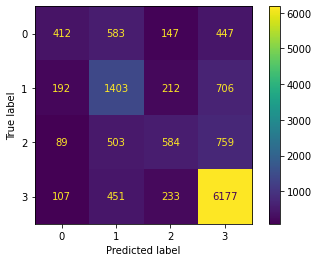

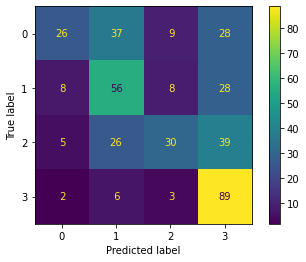

In [ ]:
# Confusion matrix whose i-th row and j-th column entry indicates 
# the number of samples with 
# true label being i-th class, and 
# predicted label being j-th class.
a = confusion_matrix(sess_gt_list, sess_pred_list)
a_per = a / np.sum(a, axis=1, keepdims=True) * 100
cm_display = ConfusionMatrixDisplay(a, display_labels=range(4)).plot(values_format='d')
cm_display = ConfusionMatrixDisplay(a_per, display_labels=range(4)).plot(values_format='2.0f')

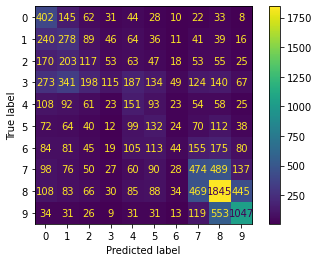

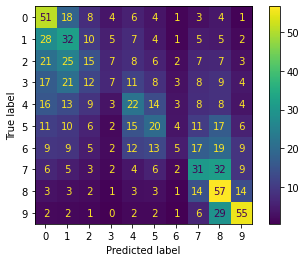

In [ ]:
a = confusion_matrix(pred_num_list, gt_num_list)
a_per = a / np.sum(a, axis=1, keepdims=True) * 100
cm_display = ConfusionMatrixDisplay(a, display_labels=range(10)).plot(values_format='d')
cm_display = ConfusionMatrixDisplay(a_per, display_labels=range(10)).plot(values_format='2.0f')

In [ ]:
s = 0
for i in range(10):
    s += a[i][i]
print(s)

4605


In [ ]:
4605 / np.sum(a)

0.35409457900807384

In [ ]:
np.sum(a)

13005

In [ ]:
a = one_zero + zero_one + one_one + zero_zero
print(one_zero)
print(zero_one)
print(one_one)
print(zero_zero) 
print('')
print(np.round(one_zero  / a, 2))
print(np.round(zero_one  / a, 2))
print(np.round(one_one   / a, 2))
print(np.round(zero_zero / a, 2)) 

[1842. 1766. 1681. 1399. 1459. 1411. 1192. 1327.  869.]
[ 489.  600.  778. 1235. 1222. 1231. 1344. 1203. 1334.]
[9831. 9651. 9357. 6867. 6842. 6742. 4269. 4093. 2000.]
[ 843.  988. 1189. 3504. 3482. 3621. 6200. 6382. 8802.]

[0.14 0.14 0.13 0.11 0.11 0.11 0.09 0.1  0.07]
[0.04 0.05 0.06 0.09 0.09 0.09 0.1  0.09 0.1 ]
[0.76 0.74 0.72 0.53 0.53 0.52 0.33 0.31 0.15]
[0.06 0.08 0.09 0.27 0.27 0.28 0.48 0.49 0.68]
